In [1]:
# Import dependencies 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from sklearn import tree
%matplotlib inline

# Database dependencies 
import psycopg2
import config as creds

In [2]:
# Connecting to database 
conn_string = "host="+ creds.PGHOST +" port="+ "5432" +" dbname="+ creds.PGDATABASE +" user=" + creds.PGUSER \
                  +" password="+ creds.PGPASSWORD
    
print(conn_string)
conn = psycopg2.connect(conn_string)

host=aws-pg-db001.chpuoe9ndogr.us-east-1.rds.amazonaws.com port=5432 dbname=covid user=postgres password=awsdbpassword001


In [5]:
# Query data table 
covid_df = pd.read_sql_query(
                   ''' SELECT * FROM coviddata 
                   ''' , conn)


In [6]:
# Drop header row 
covid_df = covid_df.iloc[1:]
covid_df.dtypes;

In [7]:
# Convert object type to float for select columns 
covid_df['meanage']=covid_df['meanage'].astype(str).astype(float)
covid_df['mortality']=covid_df['mortality'].astype(str).astype(float)
covid_df.dtypes;

Question 1: Is Age a factor in determining high risk COVID-19 mortality? 

In [8]:
# Create df with relevant columns to compare
age_plot = covid_df[['meanage','mortality']]
age_plot = age_plot.reindex()
age_plot;

In [9]:
# Rename columns 
age_plot = age_plot.rename(columns={"meanage": "Mean Age", "mortality": "Mortality"})

In [10]:
# Assign X and y variables for ML 
X = age_plot[["Mean Age"]]
y = age_plot[["Mortality"]]
print(X.shape, y.shape)

(1156, 1) (1156, 1)


Text(0.5, 1.0, 'Age vs Mortality')

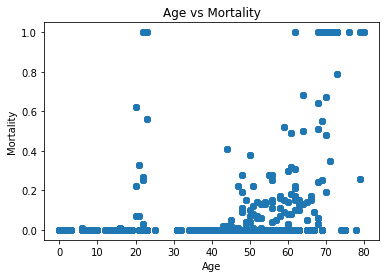

In [11]:
# Plot for any trends 
plt.scatter(X,y)
plt.xlabel('Age')
plt.ylabel('Mortality')
plt.title('Age vs Mortality')

In [12]:
# Split data for test/train 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [13]:
# Import KMeans with 6 clusters 
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=6)

In [14]:
# Fit test values to model 
kmeans.fit(X_test, y_test)

KMeans(n_clusters=6)

In [15]:
# Find predicted clusters
predicted_clusters = kmeans.predict(X_test)

In [16]:
# Calculate for centers and labels
centers = kmeans.cluster_centers_
labels = kmeans.labels_

Text(0.5, 1.0, 'Age vs Mortality')

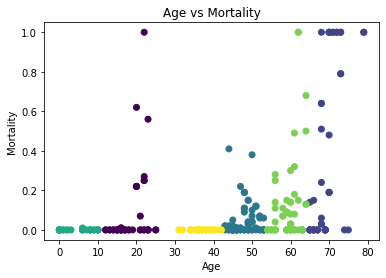

In [17]:
# Plot scatter with clusters 
plt.scatter(X_test, y_test, c = labels, cmap='viridis')
plt.xlabel('Age')
plt.ylabel('Mortality')
plt.title('Age vs Mortality')
# plt.savefig('../static/images/ageCluster.png')

In [18]:
X_test, predicted_clusters, y_test;

In [19]:
# Create new dataframe with age 
risk_age = pd.DataFrame(X_test)


In [20]:
# Reset index 
risk_age.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [21]:
# Add predicted clusters to dataframe 
predicted_clusters =pd.DataFrame(predicted_clusters)
risk_age['predicted_clusters']=predicted_clusters

In [27]:
# Add mortality to datafrmae 
risk_age['Mortality']= y_test

In [28]:
# Group by clusters 
grouped = risk_age.groupby(by=["predicted_clusters"])

In [29]:
# Find average mortality rate by clusters 
mort = grouped.mean('Mortality')

In [30]:
# Rename columns 
new_mort = mort.rename(columns={'Mortality':'AvgMortality'})

In [31]:
# Min age per clusters and rename columns 
minimum = grouped.min('Mean Age')
new_min = minimum.rename(columns={'Mean Age':'MinAge'})

# Max age per clusters and rename columns 
maximum = grouped.max('Mean Age')
new_max = maximum.rename(columns={'Mean Age':'MaxAge'})

In [32]:
# Combine into single df 
combined_df=pd.concat([new_mort, new_min, new_max],axis=1)
combined_df

,Mean Age,AvgMortality,MinAge,Mortality,MaxAge,Mortality
predicted_clusters,,,,,,
0,18.511628,0.086047,12.0,0.0,25.0,1.00
1,69.326087,0.371087,65.0,0.0,79.0,1.00
2,47.662500,0.044125,43.0,0.0,53.0,0.41
3,4.333333,0.000333,0.0,0.0,10.0,0.01
4,59.627119,0.117119,54.0,0.0,64.0,1.00
5,37.290323,0.000000,31.0,0.0,42.0,0.00


In [33]:
# Grab relevant columns to compare and sort 
results = combined_df[['MinAge','MaxAge','AvgMortality']]
end_results = results.sort_values(by=['AvgMortality'])
end_results

,MinAge,MaxAge,AvgMortality
predicted_clusters,,,
5,31.0,42.0,0.000000
3,0.0,10.0,0.000333
2,43.0,53.0,0.044125
0,12.0,25.0,0.086047
4,54.0,64.0,0.117119
1,65.0,79.0,0.371087


End of question 1 

In [32]:
# Print as csv 
end_results.to_csv ('../static/pltImages/ageRisk.csv', header=True);